<a href="https://colab.research.google.com/github/bubriks/ID2223/blob/main/Project/project-CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Course Project: Scalable Machine Learning and Deep Learning**

## **Paolo Teta & Ralfs Zangis**
---

# **Requirements**

**Tensorflow**

In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K

**Other**

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Mount Google Drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
# **1. Get the data**

**Link:** https://drive.google.com/file/d/1Du-gZz1LU-StWbahzckG1EmSLC-FuW5S/view?usp=sharing

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataset-project.csv")
df["pixels"] = [[int(y) for y in x.split(" ")] for x in df["pixels"]]

---
# **2. Explore the data**

In [5]:
print(df)

       emotion                                             pixels        usage
0            0  [70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4...     Training
1            0  [151, 150, 147, 155, 148, 133, 111, 140, 170, ...     Training
2            2  [231, 212, 156, 164, 174, 138, 161, 173, 182, ...     Training
3            4  [24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2...     Training
4            6  [4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23...     Training
...        ...                                                ...          ...
35882        6  [50, 36, 17, 22, 23, 29, 33, 39, 34, 37, 37, 3...  PrivateTest
35883        3  [178, 174, 172, 173, 181, 188, 191, 194, 196, ...  PrivateTest
35884        0  [17, 17, 16, 23, 28, 22, 19, 17, 25, 26, 20, 2...  PrivateTest
35885        3  [30, 28, 28, 29, 31, 30, 42, 68, 79, 81, 77, 6...  PrivateTest
35886        2  [19, 13, 14, 12, 13, 16, 21, 33, 50, 57, 71, 8...  PrivateTest

[35887 rows x 3 columns]


In [6]:
df.dtypes

emotion     int64
pixels     object
usage      object
dtype: object

In [7]:
print(df.count())

emotion    35887
pixels     35887
usage      35887
dtype: int64


In [8]:
print(df["usage"].value_counts())

Training       28709
PrivateTest     3589
PublicTest      3589
Name: usage, dtype: int64


In [9]:
print(df["emotion"].value_counts(sort=False))

0    4953
1     547
2    5121
3    8989
4    6077
5    4002
6    6198
Name: emotion, dtype: int64


Reshape pixels

In [10]:
df["pixels"] = [np.reshape(x, (48, 48)) for x in df["pixels"]]

Show example data

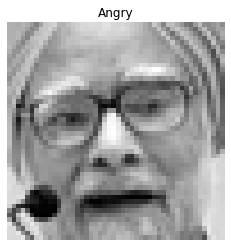

In [11]:
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

dataId = 1

row = df.iloc[dataId]
plt.figure(dataId)
pixelArray = np.asarray(row["pixels"])
plt.title(emotion_labels[row["emotion"]])
plt.axis('off')
plt.imshow(pixelArray, interpolation='none', cmap='gray')

---
# **3. Prepare data**

In [12]:
labels_num = len(df["emotion"].unique())

Rename

In [13]:
df = df.rename(columns = {"emotion": "label", "pixels": "features"}, inplace = False)

Separate dataset

In [14]:
train_df = df[df["usage"] == "Training"][["label", "features"]]
val_df = df[df["usage"] == "PublicTest"][["label", "features"]]
test_df = df[df["usage"] == "PrivateTest"][["label", "features"]]
df = None # to save memory

---
# **4. Make model**

In [15]:
def getXY(df):
    x = np.array(train_df["features"].tolist())
    y = np.array(train_df["label"])
    return (x, y)

train_x, train_y = getXY(train_df)
val_x, val_y = getXY(val_df)
test_x, test_y = getXY(test_df)

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(48, kernel_size=3, activation='relu', input_shape=(48, 48, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(48, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(48, kernel_size=3, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(labels_num)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 48)        480       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 48)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 48)        20784     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 48)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 48)          20784     
                                                                 
 flatten (Flatten)           (None, 3072)              0

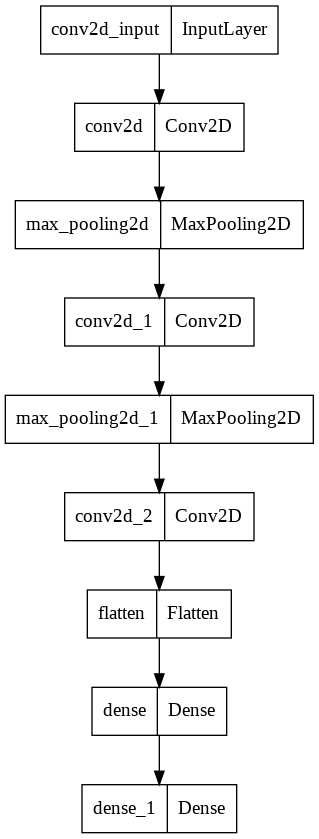

In [18]:
tf.keras.utils.plot_model(model)

---
# **5. Train model**

In [19]:
model_path = '/content/drive/MyDrive/Colab Notebooks/model.h5'

if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path)
else:
    history = model.fit(train_x, train_y, epochs=50, 
                        validation_data=(val_x, val_y))
    model.save(model_path)

Epoch 1/50
898/898 [==============================] - 17s 17ms/step - loss: 1.9409 - accuracy: 0.2830 - val_loss: 1.6631 - val_accuracy: 0.3470
Epoch 2/50
898/898 [==============================] - 14s 16ms/step - loss: 1.6018 - accuracy: 0.3747 - val_loss: 1.5264 - val_accuracy: 0.4055
Epoch 3/50
898/898 [==============================] - 14s 16ms/step - loss: 1.4962 - accuracy: 0.4218 - val_loss: 1.4103 - val_accuracy: 0.4563
Epoch 4/50
898/898 [==============================] - 16s 18ms/step - loss: 1.4158 - accuracy: 0.4546 - val_loss: 1.3148 - val_accuracy: 0.4938
Epoch 5/50
898/898 [==============================] - 14s 16ms/step - loss: 1.3364 - accuracy: 0.4859 - val_loss: 1.2849 - val_accuracy: 0.5105
Epoch 6/50
898/898 [==============================] - 15s 17ms/step - loss: 1.2565 - accuracy: 0.5205 - val_loss: 1.1628 - val_accuracy: 0.5584
Epoch 7/50
898/898 [==============================] - 14s 16ms/step - loss: 1.1818 - accuracy: 0.5526 - val_loss: 1.0918 - val_accuracy:

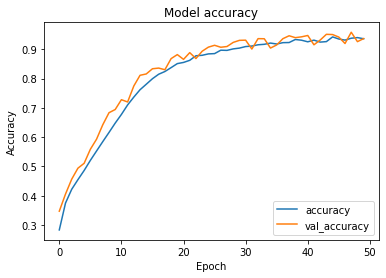

In [20]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model accuracy')
plt.legend(loc='lower right')

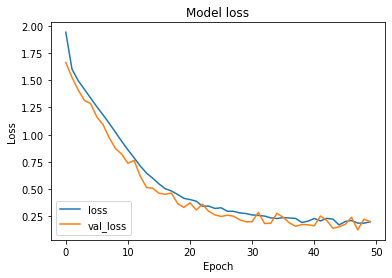

In [21]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model loss')
plt.legend(loc='lower left')

---
# **6. Prediction**

In [22]:
test_loss, test_acc = model.evaluate(test_x, test_y, verbose=2)

print('\nTest accuracy:', test_acc)

898/898 - 5s - loss: 0.2016 - accuracy: 0.9364 - 5s/epoch - 5ms/step

Test accuracy: 0.9364311099052429
